In [328]:
# trying to install Jupyter nb. The default python3.6 and pip3 are broken and I can't use it to install Jupyter nb. 
# Am fixing this. I fixed this by using the offical python3.12 installer and running `Update Shell Profile.command` afterwards
# However, I am running python3.9 instead of python3.12

# But in this Jupyter lab, I am running 3.12

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [329]:
def f(x):
  return 3*x**2 - 4*x + 5

In [330]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

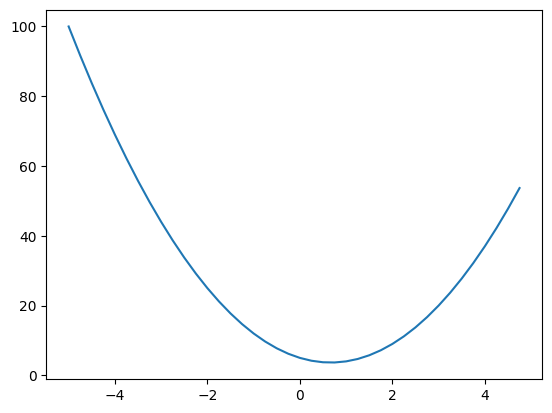

In [331]:
plt.plot(xs, ys)

In [332]:
# derivative of a function with multiple inputs
a = 1
b = 2
c = 3
d1 = 2*a*b - c

h = 0.00001

# the derivative of d with respect to a is:
a += h
d2 = 2*a*b - c
print((d2-d1)/h)

4.000000000026205


In [333]:
# starting the core Value object of micrograd
class Value():
  def __init__(self, data: float, _children=(), _op="", label=""):
    self.data = data
    self.grad = 0 # by default, we assume the gradient is 0
    self._backward = lambda : None
    self._prev = set(_children)
    self._op = _op
    self.label = label
  
  def __repr__(self) -> str:
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
      # Using += instead of = to accumulate the gradient when the param is used multiple times
      # implying it has multiple avenues to influence L
      self.grad += out.grad  
      other.grad += out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __rsub__(self, other): # other - self
    return other + (-self)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1-t**2) * out.grad
    out._backward = _backward

    return out

  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [334]:
# manual gradient calc
a.grad = 6.0
b.grad = -4.0
c.grad = -2.0
e.grad = -2.0
d.grad = -2.0
f.grad = 4.0


In [335]:

def gradient_checking():
  h = 0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

gradient_checking()

0.0


In [336]:
# One optimization step
# note that only free parameters receive an addition of the epsilon
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [337]:
# implementing a neuron with Value object
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [338]:
# again manually compute the gradient for all parameters we will be able to see the impact each inputs have on `o`. 
# Intermediate values are labeled like `x1w1x2w2` to differentiate themselves from input values

In [339]:
# step-wise automation of gradient computation
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

In [340]:
# Building the same structure but using PyTorch
# Note that I have installed the nightly version because stable PyTorch doesn't support python3.12 yet
import torch

x1 = torch.Tensor([2.]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [341]:
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x: list):
    s = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
    out = s.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.6723088554972202)

In [342]:
class Layer:
  def __init__(self, nin, nn) -> None:
    self.layer = [Neuron(nin) for _ in range(nn)]

  def __call__(self, x):
    outs = [neuron(x) for neuron in self.layer]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.layer for p in neuron.parameters()]

x = [2.0, 3.0]
l = Layer(2, 3)
l(x)

[Value(data=-0.9760932006623869),
 Value(data=-0.5582268112345695),
 Value(data=-0.9979127250571561)]

In [343]:
# This is my implementation: note that Andrej's implementation wrap `nl`, `nn` and `no` in one 
# single param `nouts`, is more flexible because number of neurons in each layer is expressed
# and thus no assumption such as mine needed to be made.
# In conclusion, his implementation is more general
class MY_MLP_IMPLEM:
  def __init__(self, ni, nl, nn, no = 1):
    # assuming the number of neurons in all hidden layers is the same
    self.nl = nl
    self.layers = [Layer(nn if i!=0 else ni, nn) for i in range(nl)]
    self.layers += [Layer(nn, no)]

  def __call__(self, x):
    # a forward pass
    out = x
    for layer in self.layers:
      out = layer(out)
    return out
  
x = [2., 3., -1.]
n = MY_MLP_IMPLEM(3, 2, 4)
n(x)

Value(data=0.870682297577472)

In [344]:
class MLP:
  def __init__(self, nin, nns):
    sz = [nin] + nns
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nns))]

  def __call__(self, x):
    # a forward pass
    out = x
    for layer in self.layers:
      out = layer(out)
    return out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [345]:
# initialize the network with one example, and do a forward pass
x = [2., 3., -1.]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.163314708230921)

In [346]:
# a tiny dataset and do a forward pass on each example in the set
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.163314708230921),
 Value(data=-0.024166038036785728),
 Value(data=-0.09888440903562773),
 Value(data=0.24930280739531968)]

In [347]:
# Writing the loss function
loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.681108614970835)

In [348]:
len(n.parameters())

41

In [349]:
# manual batch gradient descent
learning_rate = 0.01
n_iterations = 1000
for _ in range(n_iterations):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  # update
  for p in n.parameters():
    # I should be using `p.grad` instead of `p.grad/abs(p.grad)`. why?
    # because the magnitude is valuable information: when it's small,
    # I want the data update to also have a small magnitude so it doesn't
    # overshoot the minima
    p.data += -1 * learning_rate * p.grad
  
  print(loss.data)

3.681108614970835
2.8116630774021583
2.1606996471891544
1.7252794465842372
1.4316357882813286
1.2227962201782123
1.0667196915335295
0.9453521560710988
0.8480110127432197
0.7680386610022789
0.7010792339071562
0.6441569025157367
0.5951615792170107
0.5525492500160771
0.5151598952035867
0.48210245552372377
0.4526795379526143
0.4263365525596441
0.40262638305358267
0.38118424002802914
0.36170937473763076
0.3439515296324841
0.3277007313401202
0.3127794883586805
0.2990367489269271
0.28634316730190157
0.2745873561543311
0.26367289147610223
0.25351589822430864
0.24404308873576172
0.2351901574466186
0.22690045840815826
0.21912390902596746
0.21181607608604802
0.20493740965750284
0.19845259771188162
0.19233001986659828
0.18654128297003336
0.181060824608394
0.17586557325633806
0.1709346558830327
0.1662491454885769
0.16179184237738348
0.15754708404725193
0.15350057944060022
0.14963926401011513
0.14595117262788565
0.14242532784058734
0.13905164136364595
0.13582082703045875
0.1327243236812777
0.1297542

In [350]:
ypred

[Value(data=0.97452869211613),
 Value(data=-0.9752827214392236),
 Value(data=-0.9630843833158027),
 Value(data=0.9606310043551086)]